# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.95

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 200
SCHEDULER_PARIENCE = 10
COOLDOWN = 40

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 50
file_name = ""
if DATASET == "ImageNet2012":
    file_name = f"MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_name = f"MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_name += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_name

'MyResNet32_128_SGD_95'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  47500
- Length of Valid Set :  2500
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if valid_data is not None:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
else:
    valid_dataloader = None

if test_data is not None:
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("test.transforms =", test_data.transform, test_dataloader.batch_size)
else:
    test_dataloader = None

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
valid.transforms = ToTensor() 128
test.transforms = ToTensor() 128


## Confirm that the dataset is loaded properly

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
mean of X tensor([0.4931, 0.4892, 0.4587])
Shape of y: torch.Size([128]) torch.int64


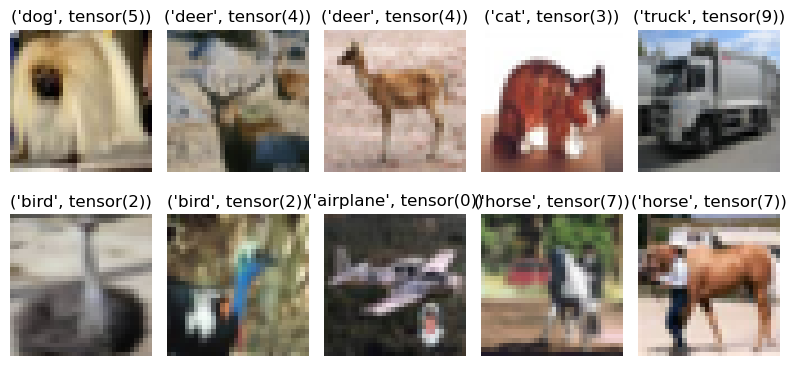

In [6]:
if test_data is not None:
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis("off")
            count += 1

            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [9]:
# model.named_modules

In [10]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [11]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [12]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [13]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [14]:
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=SCHEDULER_PARIENCE,
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=COOLDOWN,
    min_lr=1e-4,
)

# scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [15]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [16]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [17]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [18]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if optimizer.param_groups[0]["lr"] < 1e-4:
        break
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/1000] :


train: 100%|██████████| 372/372 [00:32<00:00, 11.33it/s]

Train Loss: 0.0056 | Train Acc: 25.00%


Valid Loss: 2.1756 | Valid Acc: 16.32%
Test  Loss: 2.1601 | Test Acc: 18.42%
updated best eval loss : 2.1755802989006043
--------------------------------------------------
[Epoch 2/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.45it/s]


Train Loss: 0.0055 | Train Acc: 16.67%
Valid Loss: 1.9896 | Valid Acc: 24.24%
Test  Loss: 2.0074 | Test Acc: 24.89%
updated best eval loss : 1.989634668827057
--------------------------------------------------
[Epoch 3/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.79it/s]


Train Loss: 0.0064 | Train Acc: 8.33%
Valid Loss: 1.8391 | Valid Acc: 33.84%
Test  Loss: 2.0821 | Test Acc: 26.91%
updated best eval loss : 1.8391035795211792
--------------------------------------------------
[Epoch 4/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.76it/s]


Train Loss: 0.0040 | Train Acc: 50.00%
Valid Loss: 1.4690 | Valid Acc: 48.32%
Test  Loss: 1.3600 | Test Acc: 51.81%
updated best eval loss : 1.469032210111618
--------------------------------------------------
[Epoch 5/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.84it/s]


Train Loss: 0.0051 | Train Acc: 33.33%
Valid Loss: 1.4080 | Valid Acc: 51.28%
Test  Loss: 1.3300 | Test Acc: 53.17%
updated best eval loss : 1.4080478310585023
--------------------------------------------------
[Epoch 6/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.75it/s]


Train Loss: 0.0062 | Train Acc: 33.33%
Valid Loss: 1.3762 | Valid Acc: 53.96%
Test  Loss: 1.1169 | Test Acc: 62.63%
updated best eval loss : 1.3761900067329407
--------------------------------------------------
[Epoch 7/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.92it/s]


Train Loss: 0.0025 | Train Acc: 83.33%
Valid Loss: 1.0775 | Valid Acc: 62.92%
Test  Loss: 0.9675 | Test Acc: 66.97%
updated best eval loss : 1.0775407761335374
--------------------------------------------------
[Epoch 8/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.94it/s]


Train Loss: 0.0022 | Train Acc: 75.00%
Valid Loss: 1.0377 | Valid Acc: 64.64%
Test  Loss: 1.2025 | Test Acc: 61.91%
updated best eval loss : 1.0377240628004074
--------------------------------------------------
[Epoch 9/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.61it/s]


Train Loss: 0.0031 | Train Acc: 66.67%
Valid Loss: 1.0254 | Valid Acc: 65.44%
Test  Loss: 1.1627 | Test Acc: 61.56%
updated best eval loss : 1.0254429221153258
--------------------------------------------------
[Epoch 10/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.75it/s]


Train Loss: 0.0033 | Train Acc: 75.00%
Valid Loss: 1.0400 | Valid Acc: 65.40%
Test  Loss: 0.9488 | Test Acc: 68.68%
--------------------------------------------------
[Epoch 11/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.61it/s]


Train Loss: 0.0031 | Train Acc: 58.33%
Valid Loss: 1.3985 | Valid Acc: 57.64%
Test  Loss: 0.9558 | Test Acc: 68.50%
--------------------------------------------------
[Epoch 12/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.95it/s]


Train Loss: 0.0027 | Train Acc: 58.33%
Valid Loss: 0.8358 | Valid Acc: 70.96%
Test  Loss: 0.8104 | Test Acc: 73.49%
updated best eval loss : 0.8357891499996185
--------------------------------------------------
[Epoch 13/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.85it/s]


Train Loss: 0.0033 | Train Acc: 50.00%
Valid Loss: 0.9056 | Valid Acc: 69.12%
Test  Loss: 0.8323 | Test Acc: 71.32%
--------------------------------------------------
[Epoch 14/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.54it/s]


Train Loss: 0.0040 | Train Acc: 58.33%
Valid Loss: 0.8687 | Valid Acc: 71.20%
Test  Loss: 0.7218 | Test Acc: 75.55%
--------------------------------------------------
[Epoch 15/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.95it/s]


Train Loss: 0.0023 | Train Acc: 66.67%
Valid Loss: 1.0435 | Valid Acc: 66.76%
Test  Loss: 1.0798 | Test Acc: 67.21%
--------------------------------------------------
[Epoch 16/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.87it/s]


Train Loss: 0.0039 | Train Acc: 58.33%
Valid Loss: 0.7488 | Valid Acc: 74.72%
Test  Loss: 0.7018 | Test Acc: 76.37%
updated best eval loss : 0.748834902048111
--------------------------------------------------
[Epoch 17/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.97it/s]


Train Loss: 0.0020 | Train Acc: 66.67%
Valid Loss: 0.8740 | Valid Acc: 70.08%
Test  Loss: 0.8470 | Test Acc: 71.83%
--------------------------------------------------
[Epoch 18/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.72it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.7995 | Valid Acc: 73.60%
Test  Loss: 0.6788 | Test Acc: 78.17%
--------------------------------------------------
[Epoch 19/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.71it/s]


Train Loss: 0.0024 | Train Acc: 75.00%
Valid Loss: 0.7097 | Valid Acc: 76.56%
Test  Loss: 0.6712 | Test Acc: 77.59%
updated best eval loss : 0.7096870362758636
--------------------------------------------------
[Epoch 20/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.70it/s]


Train Loss: 0.0023 | Train Acc: 75.00%
Valid Loss: 0.7976 | Valid Acc: 73.52%
Test  Loss: 0.7375 | Test Acc: 76.53%
--------------------------------------------------
[Epoch 21/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.63it/s]


Train Loss: 0.0012 | Train Acc: 83.33%
Valid Loss: 0.7711 | Valid Acc: 74.20%
Test  Loss: 0.7467 | Test Acc: 75.12%
--------------------------------------------------
[Epoch 22/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.74it/s]


Train Loss: 0.0026 | Train Acc: 66.67%
Valid Loss: 0.6827 | Valid Acc: 76.24%
Test  Loss: 0.5901 | Test Acc: 79.26%
updated best eval loss : 0.682719612121582
--------------------------------------------------
[Epoch 23/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.27it/s]


Train Loss: 0.0014 | Train Acc: 83.33%
Valid Loss: 0.7015 | Valid Acc: 75.76%
Test  Loss: 0.6851 | Test Acc: 75.86%
--------------------------------------------------
[Epoch 24/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.74it/s]


Train Loss: 0.0015 | Train Acc: 75.00%
Valid Loss: 0.7599 | Valid Acc: 73.96%
Test  Loss: 0.5561 | Test Acc: 80.61%
--------------------------------------------------
[Epoch 25/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.87it/s]


Train Loss: 0.0021 | Train Acc: 75.00%
Valid Loss: 0.7353 | Valid Acc: 74.80%
Test  Loss: 0.8826 | Test Acc: 71.90%
--------------------------------------------------
[Epoch 26/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.02it/s]


Train Loss: 0.0026 | Train Acc: 75.00%
Valid Loss: 0.7670 | Valid Acc: 74.96%
Test  Loss: 0.6139 | Test Acc: 79.45%
--------------------------------------------------
[Epoch 27/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.17it/s]


Train Loss: 0.0021 | Train Acc: 75.00%
Valid Loss: 0.8007 | Valid Acc: 73.48%
Test  Loss: 0.8398 | Test Acc: 72.79%
--------------------------------------------------
[Epoch 28/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.04it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.6891 | Valid Acc: 76.76%
Test  Loss: 0.5917 | Test Acc: 79.76%
--------------------------------------------------
[Epoch 29/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.08it/s]


Train Loss: 0.0018 | Train Acc: 75.00%
Valid Loss: 0.7561 | Valid Acc: 74.48%
Test  Loss: 0.6333 | Test Acc: 78.91%
--------------------------------------------------
[Epoch 30/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.10it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.7193 | Valid Acc: 75.56%
Test  Loss: 0.6670 | Test Acc: 77.63%
--------------------------------------------------
[Epoch 31/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.04it/s]


Train Loss: 0.0030 | Train Acc: 41.67%
Valid Loss: 0.6974 | Valid Acc: 77.00%
Test  Loss: 0.5506 | Test Acc: 81.16%
--------------------------------------------------
[Epoch 32/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.99it/s]


Train Loss: 0.0012 | Train Acc: 91.67%
Valid Loss: 0.6461 | Valid Acc: 77.88%
Test  Loss: 0.7304 | Test Acc: 76.03%
updated best eval loss : 0.6461324378848076
--------------------------------------------------
[Epoch 33/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.02it/s]


Train Loss: 0.0040 | Train Acc: 41.67%
Valid Loss: 0.8269 | Valid Acc: 72.80%
Test  Loss: 0.8036 | Test Acc: 73.73%
--------------------------------------------------
[Epoch 34/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.81it/s]


Train Loss: 0.0012 | Train Acc: 83.33%
Valid Loss: 0.6405 | Valid Acc: 78.16%
Test  Loss: 0.6350 | Test Acc: 79.61%
updated best eval loss : 0.6405304029583931
--------------------------------------------------
[Epoch 35/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.94it/s]


Train Loss: 0.0019 | Train Acc: 75.00%
Valid Loss: 0.6450 | Valid Acc: 78.12%
Test  Loss: 0.5926 | Test Acc: 79.21%
--------------------------------------------------
[Epoch 36/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.59it/s]


Train Loss: 0.0012 | Train Acc: 83.33%
Valid Loss: 0.7758 | Valid Acc: 74.40%
Test  Loss: 0.9023 | Test Acc: 71.63%
--------------------------------------------------
[Epoch 37/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.80it/s]


Train Loss: 0.0030 | Train Acc: 58.33%
Valid Loss: 0.6416 | Valid Acc: 78.40%
Test  Loss: 0.4546 | Test Acc: 84.85%
--------------------------------------------------
[Epoch 38/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.53it/s]


Train Loss: 0.0015 | Train Acc: 83.33%
Valid Loss: 0.6607 | Valid Acc: 77.00%
Test  Loss: 0.5936 | Test Acc: 80.54%
--------------------------------------------------
[Epoch 39/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.84it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.6144 | Valid Acc: 78.44%
Test  Loss: 0.5650 | Test Acc: 81.71%
updated best eval loss : 0.6144373923540115
--------------------------------------------------
[Epoch 40/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.70it/s]


Train Loss: 0.0030 | Train Acc: 58.33%
Valid Loss: 0.7623 | Valid Acc: 75.40%
Test  Loss: 0.6679 | Test Acc: 78.34%
--------------------------------------------------
[Epoch 41/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.95it/s]


Train Loss: 0.0003 | Train Acc: 100.00%
Valid Loss: 0.5891 | Valid Acc: 79.40%
Test  Loss: 0.5490 | Test Acc: 81.82%
updated best eval loss : 0.5891140937805176
--------------------------------------------------
[Epoch 42/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.01it/s]


Train Loss: 0.0014 | Train Acc: 75.00%
Valid Loss: 0.6344 | Valid Acc: 78.44%
Test  Loss: 0.7388 | Test Acc: 75.75%
--------------------------------------------------
[Epoch 43/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.93it/s]


Train Loss: 0.0012 | Train Acc: 83.33%
Valid Loss: 0.6129 | Valid Acc: 79.24%
Test  Loss: 0.6525 | Test Acc: 77.96%
--------------------------------------------------
[Epoch 44/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.67it/s]


Train Loss: 0.0019 | Train Acc: 83.33%
Valid Loss: 0.7913 | Valid Acc: 74.28%
Test  Loss: 0.5990 | Test Acc: 80.13%
--------------------------------------------------
[Epoch 45/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.83it/s]


Train Loss: 0.0017 | Train Acc: 83.33%
Valid Loss: 0.5681 | Valid Acc: 81.60%
Test  Loss: 0.4957 | Test Acc: 83.03%
updated best eval loss : 0.5681141018867493
--------------------------------------------------
[Epoch 46/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.70it/s]


Train Loss: 0.0007 | Train Acc: 83.33%
Valid Loss: 0.5966 | Valid Acc: 79.44%
Test  Loss: 0.4788 | Test Acc: 84.39%
--------------------------------------------------
[Epoch 47/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.18it/s]


Train Loss: 0.0024 | Train Acc: 75.00%
Valid Loss: 0.7589 | Valid Acc: 74.68%
Test  Loss: 0.6499 | Test Acc: 79.14%
--------------------------------------------------
[Epoch 48/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.89it/s]


Train Loss: 0.0026 | Train Acc: 58.33%
Valid Loss: 0.7210 | Valid Acc: 77.72%
Test  Loss: 0.6602 | Test Acc: 78.08%
--------------------------------------------------
[Epoch 49/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.83it/s]


Train Loss: 0.0020 | Train Acc: 83.33%
Valid Loss: 0.6140 | Valid Acc: 79.32%
Test  Loss: 0.5845 | Test Acc: 80.37%
--------------------------------------------------
[Epoch 50/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.90it/s]


Train Loss: 0.0014 | Train Acc: 83.33%
Valid Loss: 0.6116 | Valid Acc: 78.88%
Test  Loss: 0.6592 | Test Acc: 77.26%
--------------------------------------------------
[Epoch 51/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.96it/s]


Train Loss: 0.0016 | Train Acc: 83.33%
Valid Loss: 0.5732 | Valid Acc: 79.88%
Test  Loss: 0.5251 | Test Acc: 81.61%
--------------------------------------------------
[Epoch 52/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.00it/s]


Train Loss: 0.0025 | Train Acc: 75.00%
Valid Loss: 0.5806 | Valid Acc: 80.20%
Test  Loss: 0.4790 | Test Acc: 83.46%
--------------------------------------------------
[Epoch 53/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.08it/s]


Train Loss: 0.0016 | Train Acc: 83.33%
Valid Loss: 0.6105 | Valid Acc: 79.36%
Test  Loss: 0.5083 | Test Acc: 83.20%
--------------------------------------------------
[Epoch 54/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.06it/s]


Train Loss: 0.0018 | Train Acc: 75.00%
Valid Loss: 0.6094 | Valid Acc: 79.68%
Test  Loss: 0.4715 | Test Acc: 84.33%
--------------------------------------------------
[Epoch 55/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.87it/s]


Train Loss: 0.0019 | Train Acc: 75.00%
Valid Loss: 0.6326 | Valid Acc: 78.64%
Test  Loss: 0.4453 | Test Acc: 84.83%
--------------------------------------------------
[Epoch 56/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.63it/s]


Train Loss: 0.0013 | Train Acc: 83.33%
Valid Loss: 0.7081 | Valid Acc: 76.40%
Test  Loss: 0.5313 | Test Acc: 81.31%
Epoch 00056: reducing learning rate of group 0 to 1.0000e-02.
--------------------------------------------------
[Epoch 57/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.78it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.4044 | Valid Acc: 85.40%
Test  Loss: 0.3379 | Test Acc: 88.24%
updated best eval loss : 0.4043938145041466
--------------------------------------------------
[Epoch 58/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.84it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.4054 | Valid Acc: 86.08%
Test  Loss: 0.3588 | Test Acc: 87.78%
--------------------------------------------------
[Epoch 59/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.68it/s]


Train Loss: 0.0011 | Train Acc: 91.67%
Valid Loss: 0.4293 | Valid Acc: 85.56%
Test  Loss: 0.3430 | Test Acc: 88.32%
--------------------------------------------------
[Epoch 60/1000] :


train: 100%|██████████| 372/372 [00:31<00:00, 11.64it/s]


Train Loss: 0.0008 | Train Acc: 83.33%
Valid Loss: 0.3742 | Valid Acc: 87.48%
Test  Loss: 0.3348 | Test Acc: 88.72%
updated best eval loss : 0.3742076799273491
--------------------------------------------------
[Epoch 61/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.14it/s]


Train Loss: 0.0009 | Train Acc: 91.67%
Valid Loss: 0.4081 | Valid Acc: 85.40%
Test  Loss: 0.3407 | Test Acc: 88.39%
--------------------------------------------------
[Epoch 62/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.24it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3935 | Valid Acc: 87.00%
Test  Loss: 0.3081 | Test Acc: 89.52%
--------------------------------------------------
[Epoch 63/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.64it/s]


Train Loss: 0.0011 | Train Acc: 83.33%
Valid Loss: 0.4082 | Valid Acc: 86.24%
Test  Loss: 0.3478 | Test Acc: 88.40%
--------------------------------------------------
[Epoch 64/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.33it/s]


Train Loss: 0.0004 | Train Acc: 100.00%
Valid Loss: 0.4275 | Valid Acc: 85.56%
Test  Loss: 0.3287 | Test Acc: 89.00%
--------------------------------------------------
[Epoch 65/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.76it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.4042 | Valid Acc: 86.56%
Test  Loss: 0.3371 | Test Acc: 88.77%
--------------------------------------------------
[Epoch 66/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.44it/s]


Train Loss: 0.0027 | Train Acc: 66.67%
Valid Loss: 0.3858 | Valid Acc: 86.56%
Test  Loss: 0.3385 | Test Acc: 88.76%
--------------------------------------------------
[Epoch 67/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.61it/s]


Train Loss: 0.0010 | Train Acc: 91.67%
Valid Loss: 0.4150 | Valid Acc: 85.76%
Test  Loss: 0.3322 | Test Acc: 88.72%
--------------------------------------------------
[Epoch 68/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.40it/s]


Train Loss: 0.0022 | Train Acc: 75.00%
Valid Loss: 0.3771 | Valid Acc: 86.84%
Test  Loss: 0.3425 | Test Acc: 88.99%
--------------------------------------------------
[Epoch 69/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.24it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.4065 | Valid Acc: 86.08%
Test  Loss: 0.3291 | Test Acc: 89.26%
--------------------------------------------------
[Epoch 70/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.22it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3984 | Valid Acc: 87.24%
Test  Loss: 0.3301 | Test Acc: 89.09%
--------------------------------------------------
[Epoch 71/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.12it/s]


Train Loss: 0.0014 | Train Acc: 75.00%
Valid Loss: 0.4089 | Valid Acc: 86.12%
Test  Loss: 0.3414 | Test Acc: 89.00%
--------------------------------------------------
[Epoch 72/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.79it/s]


Train Loss: 0.0010 | Train Acc: 91.67%
Valid Loss: 0.3647 | Valid Acc: 88.24%
Test  Loss: 0.3290 | Test Acc: 89.19%
updated best eval loss : 0.3647132232785225
--------------------------------------------------
[Epoch 73/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.31it/s]


Train Loss: 0.0016 | Train Acc: 83.33%
Valid Loss: 0.3906 | Valid Acc: 87.36%
Test  Loss: 0.3512 | Test Acc: 88.23%
--------------------------------------------------
[Epoch 74/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.97it/s]


Train Loss: 0.0011 | Train Acc: 91.67%
Valid Loss: 0.3900 | Valid Acc: 86.64%
Test  Loss: 0.3504 | Test Acc: 88.29%
--------------------------------------------------
[Epoch 75/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 13.00it/s]


Train Loss: 0.0012 | Train Acc: 75.00%
Valid Loss: 0.3932 | Valid Acc: 86.92%
Test  Loss: 0.3345 | Test Acc: 88.85%
--------------------------------------------------
[Epoch 76/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.54it/s]


Train Loss: 0.0003 | Train Acc: 91.67%
Valid Loss: 0.4128 | Valid Acc: 86.00%
Test  Loss: 0.3705 | Test Acc: 88.12%
--------------------------------------------------
[Epoch 77/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.30it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.4041 | Valid Acc: 86.36%
Test  Loss: 0.3492 | Test Acc: 88.69%
--------------------------------------------------
[Epoch 78/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.74it/s]


Train Loss: 0.0017 | Train Acc: 91.67%
Valid Loss: 0.3988 | Valid Acc: 86.92%
Test  Loss: 0.3281 | Test Acc: 89.14%
--------------------------------------------------
[Epoch 79/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.61it/s]


Train Loss: 0.0025 | Train Acc: 75.00%
Valid Loss: 0.3737 | Valid Acc: 87.36%
Test  Loss: 0.3293 | Test Acc: 89.32%
--------------------------------------------------
[Epoch 80/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.44it/s]


Train Loss: 0.0011 | Train Acc: 91.67%
Valid Loss: 0.3940 | Valid Acc: 86.80%
Test  Loss: 0.3198 | Test Acc: 89.59%
--------------------------------------------------
[Epoch 81/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.78it/s]


Train Loss: 0.0003 | Train Acc: 91.67%
Valid Loss: 0.3966 | Valid Acc: 87.48%
Test  Loss: 0.3452 | Test Acc: 88.69%
--------------------------------------------------
[Epoch 82/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.48it/s]


Train Loss: 0.0018 | Train Acc: 91.67%
Valid Loss: 0.3841 | Valid Acc: 86.88%
Test  Loss: 0.3218 | Test Acc: 89.39%
--------------------------------------------------
[Epoch 83/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.65it/s]


Train Loss: 0.0003 | Train Acc: 100.00%
Valid Loss: 0.3667 | Valid Acc: 88.04%
Test  Loss: 0.3294 | Test Acc: 89.35%
--------------------------------------------------
[Epoch 84/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.68it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3704 | Valid Acc: 87.40%
Test  Loss: 0.3414 | Test Acc: 88.97%
--------------------------------------------------
[Epoch 85/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.58it/s]


Train Loss: 0.0021 | Train Acc: 83.33%
Valid Loss: 0.3973 | Valid Acc: 86.60%
Test  Loss: 0.3213 | Test Acc: 89.45%
--------------------------------------------------
[Epoch 86/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.78it/s]


Train Loss: 0.0004 | Train Acc: 100.00%
Valid Loss: 0.3874 | Valid Acc: 87.00%
Test  Loss: 0.3242 | Test Acc: 89.49%
--------------------------------------------------
[Epoch 87/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.42it/s]


Train Loss: 0.0020 | Train Acc: 66.67%
Valid Loss: 0.3778 | Valid Acc: 87.20%
Test  Loss: 0.3345 | Test Acc: 89.26%
--------------------------------------------------
[Epoch 88/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.87it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.3887 | Valid Acc: 87.52%
Test  Loss: 0.3548 | Test Acc: 88.70%
--------------------------------------------------
[Epoch 89/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.60it/s]


Train Loss: 0.0016 | Train Acc: 75.00%
Valid Loss: 0.4029 | Valid Acc: 86.52%
Test  Loss: 0.3447 | Test Acc: 88.75%
--------------------------------------------------
[Epoch 90/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.40it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3872 | Valid Acc: 86.72%
Test  Loss: 0.3431 | Test Acc: 88.98%
--------------------------------------------------
[Epoch 91/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.60it/s]


Train Loss: 0.0008 | Train Acc: 83.33%
Valid Loss: 0.3839 | Valid Acc: 87.20%
Test  Loss: 0.3518 | Test Acc: 88.20%
--------------------------------------------------
[Epoch 92/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.29it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3787 | Valid Acc: 87.40%
Test  Loss: 0.3349 | Test Acc: 89.00%
--------------------------------------------------
[Epoch 93/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.73it/s]


Train Loss: 0.0015 | Train Acc: 66.67%
Valid Loss: 0.4055 | Valid Acc: 86.52%
Test  Loss: 0.3688 | Test Acc: 88.08%
--------------------------------------------------
[Epoch 94/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.79it/s]


Train Loss: 0.0017 | Train Acc: 66.67%
Valid Loss: 0.3719 | Valid Acc: 88.00%
Test  Loss: 0.3258 | Test Acc: 89.23%
--------------------------------------------------
[Epoch 95/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.95it/s]


Train Loss: 0.0011 | Train Acc: 91.67%
Valid Loss: 0.3924 | Valid Acc: 86.32%
Test  Loss: 0.3515 | Test Acc: 89.04%
--------------------------------------------------
[Epoch 96/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.60it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.3791 | Valid Acc: 86.92%
Test  Loss: 0.3419 | Test Acc: 89.30%
--------------------------------------------------
[Epoch 97/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.33it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3957 | Valid Acc: 86.92%
Test  Loss: 0.3095 | Test Acc: 90.00%
--------------------------------------------------
[Epoch 98/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.61it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3800 | Valid Acc: 86.80%
Test  Loss: 0.3096 | Test Acc: 89.97%
--------------------------------------------------
[Epoch 99/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.44it/s]


Train Loss: 0.0010 | Train Acc: 91.67%
Valid Loss: 0.3841 | Valid Acc: 87.16%
Test  Loss: 0.3404 | Test Acc: 89.06%
--------------------------------------------------
[Epoch 100/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.73it/s]


Train Loss: 0.0012 | Train Acc: 75.00%
Valid Loss: 0.3856 | Valid Acc: 86.64%
Test  Loss: 0.3287 | Test Acc: 89.40%
--------------------------------------------------
[Epoch 101/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.89it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.4058 | Valid Acc: 86.60%
Test  Loss: 0.3352 | Test Acc: 89.27%
--------------------------------------------------
[Epoch 102/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3704 | Valid Acc: 88.44%
Test  Loss: 0.3413 | Test Acc: 89.21%
--------------------------------------------------
[Epoch 103/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.82it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3952 | Valid Acc: 87.20%
Test  Loss: 0.3603 | Test Acc: 88.47%
--------------------------------------------------
[Epoch 104/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.77it/s]


Train Loss: 0.0011 | Train Acc: 91.67%
Valid Loss: 0.4040 | Valid Acc: 85.96%
Test  Loss: 0.3344 | Test Acc: 89.35%
--------------------------------------------------
[Epoch 105/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.37it/s]


Train Loss: 0.0051 | Train Acc: 66.67%
Valid Loss: 0.3827 | Valid Acc: 87.28%
Test  Loss: 0.3737 | Test Acc: 87.86%
--------------------------------------------------
[Epoch 106/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.44it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.4015 | Valid Acc: 86.64%
Test  Loss: 0.3646 | Test Acc: 88.43%
--------------------------------------------------
[Epoch 107/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.53it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.4066 | Valid Acc: 87.08%
Test  Loss: 0.3334 | Test Acc: 89.51%
--------------------------------------------------
[Epoch 108/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.50it/s]


Train Loss: 0.0012 | Train Acc: 83.33%
Valid Loss: 0.3909 | Valid Acc: 87.24%
Test  Loss: 0.3306 | Test Acc: 89.38%
--------------------------------------------------
[Epoch 109/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.67it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3939 | Valid Acc: 86.56%
Test  Loss: 0.3471 | Test Acc: 88.55%
--------------------------------------------------
[Epoch 110/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.54it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3710 | Valid Acc: 87.68%
Test  Loss: 0.3292 | Test Acc: 89.15%
--------------------------------------------------
[Epoch 111/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.80it/s]


Train Loss: 0.0015 | Train Acc: 75.00%
Valid Loss: 0.3764 | Valid Acc: 87.64%
Test  Loss: 0.3578 | Test Acc: 88.41%
--------------------------------------------------
[Epoch 112/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.61it/s]


Train Loss: 0.0030 | Train Acc: 66.67%
Valid Loss: 0.4071 | Valid Acc: 86.28%
Test  Loss: 0.3889 | Test Acc: 87.84%
--------------------------------------------------
[Epoch 113/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.30it/s]


Train Loss: 0.0016 | Train Acc: 83.33%
Valid Loss: 0.4074 | Valid Acc: 87.04%
Test  Loss: 0.3744 | Test Acc: 87.83%
--------------------------------------------------
[Epoch 114/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.52it/s]


Train Loss: 0.0013 | Train Acc: 75.00%
Valid Loss: 0.3684 | Valid Acc: 87.56%
Test  Loss: 0.3830 | Test Acc: 87.79%
--------------------------------------------------
[Epoch 115/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.38it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3817 | Valid Acc: 87.64%
Test  Loss: 0.3535 | Test Acc: 88.73%
--------------------------------------------------
[Epoch 116/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.44it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.4101 | Valid Acc: 86.24%
Test  Loss: 0.3246 | Test Acc: 89.61%
--------------------------------------------------
[Epoch 117/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.39it/s]


Train Loss: 0.0011 | Train Acc: 83.33%
Valid Loss: 0.3728 | Valid Acc: 87.44%
Test  Loss: 0.3746 | Test Acc: 88.36%
Epoch 00117: reducing learning rate of group 0 to 1.0000e-03.
--------------------------------------------------
[Epoch 118/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.51it/s]


Train Loss: 0.0018 | Train Acc: 75.00%
Valid Loss: 0.3751 | Valid Acc: 87.80%
Test  Loss: 0.3447 | Test Acc: 89.12%
--------------------------------------------------
[Epoch 119/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.67it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3840 | Valid Acc: 87.48%
Test  Loss: 0.3347 | Test Acc: 89.45%
--------------------------------------------------
[Epoch 120/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.38it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3639 | Valid Acc: 87.92%
Test  Loss: 0.3340 | Test Acc: 89.29%
updated best eval loss : 0.3639434240758419
--------------------------------------------------
[Epoch 121/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.41it/s]


Train Loss: 0.0008 | Train Acc: 83.33%
Valid Loss: 0.3479 | Valid Acc: 88.56%
Test  Loss: 0.3420 | Test Acc: 89.17%
updated best eval loss : 0.3478687711060047
--------------------------------------------------
[Epoch 122/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.56it/s]


Train Loss: 0.0014 | Train Acc: 91.67%
Valid Loss: 0.3720 | Valid Acc: 88.24%
Test  Loss: 0.3266 | Test Acc: 89.77%
--------------------------------------------------
[Epoch 123/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.64it/s]


Train Loss: 0.0016 | Train Acc: 75.00%
Valid Loss: 0.3664 | Valid Acc: 88.08%
Test  Loss: 0.3246 | Test Acc: 89.79%
--------------------------------------------------
[Epoch 124/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.55it/s]


Train Loss: 0.0012 | Train Acc: 83.33%
Valid Loss: 0.3867 | Valid Acc: 87.92%
Test  Loss: 0.3102 | Test Acc: 90.29%
--------------------------------------------------
[Epoch 125/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.66it/s]


Train Loss: 0.0015 | Train Acc: 75.00%
Valid Loss: 0.3830 | Valid Acc: 87.96%
Test  Loss: 0.3100 | Test Acc: 90.37%
--------------------------------------------------
[Epoch 126/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.63it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3644 | Valid Acc: 88.00%
Test  Loss: 0.3144 | Test Acc: 90.27%
--------------------------------------------------
[Epoch 127/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.53it/s]


Train Loss: 0.0023 | Train Acc: 75.00%
Valid Loss: 0.3933 | Valid Acc: 88.16%
Test  Loss: 0.3209 | Test Acc: 90.32%
--------------------------------------------------
[Epoch 128/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.20it/s]


Train Loss: 0.0026 | Train Acc: 58.33%
Valid Loss: 0.3696 | Valid Acc: 88.04%
Test  Loss: 0.3337 | Test Acc: 89.75%
--------------------------------------------------
[Epoch 129/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.57it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.3784 | Valid Acc: 86.92%
Test  Loss: 0.3221 | Test Acc: 89.93%
--------------------------------------------------
[Epoch 130/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.30it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.3604 | Valid Acc: 88.04%
Test  Loss: 0.3215 | Test Acc: 89.85%
--------------------------------------------------
[Epoch 131/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.36it/s]


Train Loss: 0.0003 | Train Acc: 91.67%
Valid Loss: 0.3680 | Valid Acc: 88.56%
Test  Loss: 0.3195 | Test Acc: 90.20%
--------------------------------------------------
[Epoch 132/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.42it/s]


Train Loss: 0.0011 | Train Acc: 91.67%
Valid Loss: 0.3393 | Valid Acc: 88.28%
Test  Loss: 0.3105 | Test Acc: 90.43%
updated best eval loss : 0.3393141582608223
--------------------------------------------------
[Epoch 133/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.62it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3722 | Valid Acc: 87.72%
Test  Loss: 0.3247 | Test Acc: 89.73%
--------------------------------------------------
[Epoch 134/1000] :


train: 100%|██████████| 372/372 [00:27<00:00, 13.64it/s]


Train Loss: 0.0009 | Train Acc: 83.33%
Valid Loss: 0.3711 | Valid Acc: 88.04%
Test  Loss: 0.3265 | Test Acc: 89.87%
--------------------------------------------------
[Epoch 135/1000] :


train: 100%|██████████| 372/372 [00:31<00:00, 11.74it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3338 | Valid Acc: 89.32%
Test  Loss: 0.3326 | Test Acc: 89.41%
updated best eval loss : 0.33383524119853974
--------------------------------------------------
[Epoch 136/1000] :


train: 100%|██████████| 372/372 [00:31<00:00, 11.77it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3569 | Valid Acc: 88.40%
Test  Loss: 0.3222 | Test Acc: 89.71%
--------------------------------------------------
[Epoch 137/1000] :


train: 100%|██████████| 372/372 [00:31<00:00, 11.99it/s]


Train Loss: 0.0009 | Train Acc: 83.33%
Valid Loss: 0.3361 | Valid Acc: 88.52%
Test  Loss: 0.3163 | Test Acc: 90.19%
--------------------------------------------------
[Epoch 138/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.26it/s]


Train Loss: 0.0003 | Train Acc: 91.67%
Valid Loss: 0.3762 | Valid Acc: 87.56%
Test  Loss: 0.3144 | Test Acc: 90.13%
--------------------------------------------------
[Epoch 139/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.28it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3854 | Valid Acc: 87.56%
Test  Loss: 0.3287 | Test Acc: 89.74%
--------------------------------------------------
[Epoch 140/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.42it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3479 | Valid Acc: 88.92%
Test  Loss: 0.3144 | Test Acc: 90.38%
--------------------------------------------------
[Epoch 141/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.46it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3914 | Valid Acc: 87.12%
Test  Loss: 0.3274 | Test Acc: 89.68%
--------------------------------------------------
[Epoch 142/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.36it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.3826 | Valid Acc: 87.60%
Test  Loss: 0.3261 | Test Acc: 89.95%
--------------------------------------------------
[Epoch 143/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.41it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3767 | Valid Acc: 87.92%
Test  Loss: 0.3186 | Test Acc: 90.01%
--------------------------------------------------
[Epoch 144/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.47it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3841 | Valid Acc: 87.68%
Test  Loss: 0.3140 | Test Acc: 90.30%
--------------------------------------------------
[Epoch 145/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.53it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3514 | Valid Acc: 88.96%
Test  Loss: 0.3199 | Test Acc: 89.98%
--------------------------------------------------
[Epoch 146/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.02it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3500 | Valid Acc: 88.64%
Test  Loss: 0.3197 | Test Acc: 90.05%
--------------------------------------------------
[Epoch 147/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.43it/s]


Train Loss: 0.0027 | Train Acc: 75.00%
Valid Loss: 0.3703 | Valid Acc: 88.60%
Test  Loss: 0.3250 | Test Acc: 89.96%
--------------------------------------------------
[Epoch 148/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.64it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3735 | Valid Acc: 87.84%
Test  Loss: 0.3267 | Test Acc: 89.84%
--------------------------------------------------
[Epoch 149/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.38it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3759 | Valid Acc: 87.28%
Test  Loss: 0.3319 | Test Acc: 89.69%
--------------------------------------------------
[Epoch 150/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.44it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3584 | Valid Acc: 88.36%
Test  Loss: 0.3240 | Test Acc: 89.83%
--------------------------------------------------
[Epoch 151/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.46it/s]


Train Loss: 0.0012 | Train Acc: 91.67%
Valid Loss: 0.3649 | Valid Acc: 89.08%
Test  Loss: 0.3162 | Test Acc: 90.20%
--------------------------------------------------
[Epoch 152/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.65it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3773 | Valid Acc: 87.84%
Test  Loss: 0.3233 | Test Acc: 89.91%
--------------------------------------------------
[Epoch 153/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.51it/s]


Train Loss: 0.0016 | Train Acc: 91.67%
Valid Loss: 0.3854 | Valid Acc: 87.32%
Test  Loss: 0.3236 | Test Acc: 89.86%
--------------------------------------------------
[Epoch 154/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.64it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3659 | Valid Acc: 88.00%
Test  Loss: 0.3242 | Test Acc: 89.86%
--------------------------------------------------
[Epoch 155/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.69it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3780 | Valid Acc: 87.80%
Test  Loss: 0.3140 | Test Acc: 90.22%
--------------------------------------------------
[Epoch 156/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.28it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3745 | Valid Acc: 88.80%
Test  Loss: 0.3109 | Test Acc: 90.44%
--------------------------------------------------
[Epoch 157/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.73it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3661 | Valid Acc: 88.20%
Test  Loss: 0.3276 | Test Acc: 89.75%
--------------------------------------------------
[Epoch 158/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.55it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3727 | Valid Acc: 88.08%
Test  Loss: 0.3189 | Test Acc: 90.09%
--------------------------------------------------
[Epoch 159/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.28it/s]


Train Loss: 0.0009 | Train Acc: 83.33%
Valid Loss: 0.3593 | Valid Acc: 87.96%
Test  Loss: 0.3185 | Test Acc: 90.17%
--------------------------------------------------
[Epoch 160/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.42it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3715 | Valid Acc: 88.04%
Test  Loss: 0.3195 | Test Acc: 89.93%
--------------------------------------------------
[Epoch 161/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.54it/s]


Train Loss: 0.0019 | Train Acc: 75.00%
Valid Loss: 0.3733 | Valid Acc: 88.28%
Test  Loss: 0.3300 | Test Acc: 89.78%
--------------------------------------------------
[Epoch 162/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.59it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3493 | Valid Acc: 89.08%
Test  Loss: 0.3249 | Test Acc: 90.16%
--------------------------------------------------
[Epoch 163/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.58it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.3587 | Valid Acc: 88.24%
Test  Loss: 0.3152 | Test Acc: 90.16%
--------------------------------------------------
[Epoch 164/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.38it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3650 | Valid Acc: 88.36%
Test  Loss: 0.3213 | Test Acc: 89.94%
--------------------------------------------------
[Epoch 165/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.81it/s]


Train Loss: 0.0011 | Train Acc: 75.00%
Valid Loss: 0.3394 | Valid Acc: 88.12%
Test  Loss: 0.3273 | Test Acc: 89.94%
--------------------------------------------------
[Epoch 166/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.79it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3678 | Valid Acc: 88.64%
Test  Loss: 0.3186 | Test Acc: 89.82%
--------------------------------------------------
[Epoch 167/1000] :


train: 100%|██████████| 372/372 [00:28<00:00, 12.85it/s]


Train Loss: 0.0019 | Train Acc: 83.33%
Valid Loss: 0.3699 | Valid Acc: 88.04%
Test  Loss: 0.3250 | Test Acc: 89.81%
--------------------------------------------------
[Epoch 168/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.49it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3793 | Valid Acc: 87.32%
Test  Loss: 0.3410 | Test Acc: 89.47%
--------------------------------------------------
[Epoch 169/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.64it/s]


Train Loss: 0.0014 | Train Acc: 91.67%
Valid Loss: 0.3583 | Valid Acc: 88.08%
Test  Loss: 0.3220 | Test Acc: 89.87%
--------------------------------------------------
[Epoch 170/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.42it/s]


Train Loss: 0.0017 | Train Acc: 83.33%
Valid Loss: 0.3833 | Valid Acc: 87.28%
Test  Loss: 0.3218 | Test Acc: 89.95%
--------------------------------------------------
[Epoch 171/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.61it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3736 | Valid Acc: 88.24%
Test  Loss: 0.3308 | Test Acc: 89.84%
--------------------------------------------------
[Epoch 172/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.30it/s]


Train Loss: 0.0010 | Train Acc: 91.67%
Valid Loss: 0.3877 | Valid Acc: 87.88%
Test  Loss: 0.3375 | Test Acc: 89.81%
--------------------------------------------------
[Epoch 173/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.63it/s]


Train Loss: 0.0008 | Train Acc: 83.33%
Valid Loss: 0.3658 | Valid Acc: 87.68%
Test  Loss: 0.3217 | Test Acc: 90.07%
--------------------------------------------------
[Epoch 174/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.66it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3855 | Valid Acc: 87.44%
Test  Loss: 0.3270 | Test Acc: 89.78%
--------------------------------------------------
[Epoch 175/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.67it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3611 | Valid Acc: 88.48%
Test  Loss: 0.3304 | Test Acc: 89.74%
--------------------------------------------------
[Epoch 176/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.64it/s]


Train Loss: 0.0009 | Train Acc: 91.67%
Valid Loss: 0.3794 | Valid Acc: 87.28%
Test  Loss: 0.3230 | Test Acc: 90.04%
--------------------------------------------------
[Epoch 177/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.43it/s]


Train Loss: 0.0012 | Train Acc: 91.67%
Valid Loss: 0.3733 | Valid Acc: 87.96%
Test  Loss: 0.3178 | Test Acc: 89.98%
--------------------------------------------------
[Epoch 178/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.53it/s]


Train Loss: 0.0033 | Train Acc: 83.33%
Valid Loss: 0.3549 | Valid Acc: 88.68%
Test  Loss: 0.3388 | Test Acc: 89.64%
Epoch 00178: reducing learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
[Epoch 179/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.78it/s]


Train Loss: 0.0016 | Train Acc: 91.67%
Valid Loss: 0.4012 | Valid Acc: 87.76%
Test  Loss: 0.3196 | Test Acc: 90.10%
--------------------------------------------------
[Epoch 180/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.81it/s]


Train Loss: 0.0007 | Train Acc: 100.00%
Valid Loss: 0.3686 | Valid Acc: 88.36%
Test  Loss: 0.3309 | Test Acc: 89.72%
--------------------------------------------------
[Epoch 181/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.64it/s]


Train Loss: 0.0012 | Train Acc: 83.33%
Valid Loss: 0.3680 | Valid Acc: 88.52%
Test  Loss: 0.3168 | Test Acc: 90.20%
--------------------------------------------------
[Epoch 182/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.41it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3503 | Valid Acc: 88.68%
Test  Loss: 0.3443 | Test Acc: 89.20%
--------------------------------------------------
[Epoch 183/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.77it/s]


Train Loss: 0.0003 | Train Acc: 100.00%
Valid Loss: 0.3603 | Valid Acc: 87.80%
Test  Loss: 0.3348 | Test Acc: 89.84%
--------------------------------------------------
[Epoch 184/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.52it/s]


Train Loss: 0.0006 | Train Acc: 83.33%
Valid Loss: 0.3751 | Valid Acc: 87.32%
Test  Loss: 0.3342 | Test Acc: 89.66%
--------------------------------------------------
[Epoch 185/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.52it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3594 | Valid Acc: 89.08%
Test  Loss: 0.3369 | Test Acc: 89.86%
--------------------------------------------------
[Epoch 186/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.50it/s]


Train Loss: 0.0011 | Train Acc: 75.00%
Valid Loss: 0.3668 | Valid Acc: 88.16%
Test  Loss: 0.3278 | Test Acc: 89.97%
--------------------------------------------------
[Epoch 187/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.51it/s]


Train Loss: 0.0004 | Train Acc: 100.00%
Valid Loss: 0.3711 | Valid Acc: 88.16%
Test  Loss: 0.3365 | Test Acc: 89.57%
--------------------------------------------------
[Epoch 188/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.38it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3770 | Valid Acc: 87.52%
Test  Loss: 0.3243 | Test Acc: 90.00%
--------------------------------------------------
[Epoch 189/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.40it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3487 | Valid Acc: 88.92%
Test  Loss: 0.3191 | Test Acc: 90.01%
--------------------------------------------------
[Epoch 190/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.4003 | Valid Acc: 87.52%
Test  Loss: 0.3286 | Test Acc: 89.75%
--------------------------------------------------
[Epoch 191/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.34it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3716 | Valid Acc: 88.48%
Test  Loss: 0.3308 | Test Acc: 89.97%
--------------------------------------------------
[Epoch 192/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.59it/s]


Train Loss: 0.0003 | Train Acc: 91.67%
Valid Loss: 0.3830 | Valid Acc: 87.92%
Test  Loss: 0.3250 | Test Acc: 89.93%
--------------------------------------------------
[Epoch 193/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.51it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3739 | Valid Acc: 88.24%
Test  Loss: 0.3260 | Test Acc: 89.78%
--------------------------------------------------
[Epoch 194/1000] :


train: 100%|██████████| 372/372 [00:30<00:00, 12.38it/s]


Train Loss: 0.0015 | Train Acc: 83.33%
Valid Loss: 0.3760 | Valid Acc: 88.08%
Test  Loss: 0.3202 | Test Acc: 90.14%
--------------------------------------------------
[Epoch 195/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.58it/s]


Train Loss: 0.0015 | Train Acc: 83.33%
Valid Loss: 0.3464 | Valid Acc: 88.36%
Test  Loss: 0.3210 | Test Acc: 89.91%
--------------------------------------------------
[Epoch 196/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.45it/s]


Train Loss: 0.0010 | Train Acc: 75.00%
Valid Loss: 0.3953 | Valid Acc: 88.08%
Test  Loss: 0.3188 | Test Acc: 90.11%
--------------------------------------------------
[Epoch 197/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.67it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3597 | Valid Acc: 88.28%
Test  Loss: 0.3206 | Test Acc: 89.92%
--------------------------------------------------
[Epoch 198/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.75it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3598 | Valid Acc: 88.36%
Test  Loss: 0.3350 | Test Acc: 89.49%
--------------------------------------------------
[Epoch 199/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.57it/s]


Train Loss: 0.0012 | Train Acc: 91.67%
Valid Loss: 0.3778 | Valid Acc: 88.00%
Test  Loss: 0.3301 | Test Acc: 89.83%
--------------------------------------------------
[Epoch 200/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.62it/s]


Train Loss: 0.0013 | Train Acc: 83.33%
Valid Loss: 0.3886 | Valid Acc: 87.40%
Test  Loss: 0.3312 | Test Acc: 89.80%
--------------------------------------------------
[Epoch 201/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.44it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.3474 | Valid Acc: 88.68%
Test  Loss: 0.3373 | Test Acc: 89.57%
--------------------------------------------------
[Epoch 202/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.50it/s]


Train Loss: 0.0018 | Train Acc: 83.33%
Valid Loss: 0.3846 | Valid Acc: 87.76%
Test  Loss: 0.3294 | Test Acc: 89.55%
--------------------------------------------------
[Epoch 203/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.66it/s]


Train Loss: 0.0015 | Train Acc: 91.67%
Valid Loss: 0.3562 | Valid Acc: 88.72%
Test  Loss: 0.3266 | Test Acc: 89.99%
--------------------------------------------------
[Epoch 204/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.55it/s]


Train Loss: 0.0008 | Train Acc: 83.33%
Valid Loss: 0.3692 | Valid Acc: 88.00%
Test  Loss: 0.3319 | Test Acc: 89.53%
--------------------------------------------------
[Epoch 205/1000] :


train: 100%|██████████| 372/372 [00:29<00:00, 12.43it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3762 | Valid Acc: 87.68%
Test  Loss: 0.3334 | Test Acc: 89.53%
Early stop!! best_eval_loss = 0.33383524119853974


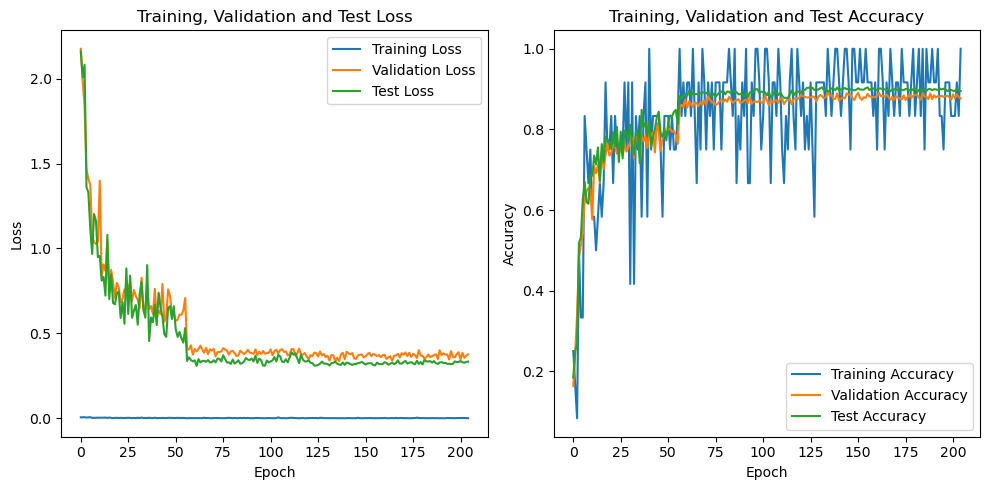

In [20]:
view = LogViewer(logs)
view.draw(file_name)

In [21]:
view.print_all()

1 epoch: train_loss=0.0056, train_acc=0.2500, test_loss=2.1601, test_acc=0.1842, valid_loss=2.1756, valid_acc=0.1632, lr=0.1000
2 epoch: train_loss=0.0055, train_acc=0.1667, test_loss=2.0074, test_acc=0.2489, valid_loss=1.9896, valid_acc=0.2424, lr=0.1000
3 epoch: train_loss=0.0064, train_acc=0.0833, test_loss=2.0821, test_acc=0.2691, valid_loss=1.8391, valid_acc=0.3384, lr=0.1000
4 epoch: train_loss=0.0040, train_acc=0.5000, test_loss=1.3600, test_acc=0.5181, valid_loss=1.4690, valid_acc=0.4832, lr=0.1000
5 epoch: train_loss=0.0051, train_acc=0.3333, test_loss=1.3300, test_acc=0.5317, valid_loss=1.4080, valid_acc=0.5128, lr=0.1000
6 epoch: train_loss=0.0062, train_acc=0.3333, test_loss=1.1169, test_acc=0.6263, valid_loss=1.3762, valid_acc=0.5396, lr=0.1000
7 epoch: train_loss=0.0025, train_acc=0.8333, test_loss=0.9675, test_acc=0.6697, valid_loss=1.0775, valid_acc=0.6292, lr=0.1000
8 epoch: train_loss=0.0022, train_acc=0.7500, test_loss=1.2025, test_acc=0.6191, valid_loss=1.0377, vali

In [22]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))